// dataset sources: 
- https://www.kaggle.com/datasets/teamincribo/cyber-security-attacks?select=cybersecurity_attacks.csv
- https://www.unb.ca/cic/datasets/ids-2017.html
- https://www.iana.org/assignments/service-names-port-numbers/service-names-port-numbers.csv

## Environment Setup
Python 3.13
Required packages:
- pandas==2.x
- numpy==1.x
- geoip2==4.x
- plotly==5.x
- scikit-learn==1.x
- xgboost, catboost, lightgbm
- pycountry, tqdm, seaborn, matplotlib

In [2]:
import sys
import pandas as pd
import numpy as np
import geoip2.database
from tqdm import tqdm
import plotly.express as px
import pycountry
import plotly.io as pio
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score, accuracy_score
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb
import copy
from pathlib import Path
import os

import warnings
warnings.filterwarnings('ignore')


In [3]:
pio.renderers.default = "browser"


In [ ]:
# RUN FIRST

!pip install -r requirements.txt

# After installing all dependencies, please run cell FIRST

In [5]:
# PATH SETUP, run thsis cell first to set up paths

NOTEBOOK_DIR = Path.cwd() # This is to get the directory where this notebook is located

# defining data paths for easy recall later on

DATA_DIR = NOTEBOOK_DIR / "datasets"
GEO_DB_PATH = DATA_DIR / "GeoLite2-City.mmdb"
CYBER_ATTACKS_PATH = DATA_DIR / "cybersecurity_attacks.csv"
TRAFFIC_DIR = DATA_DIR / "GeneratedLabelledFlows" / "TrafficLabelling"
PORTS_PATH = DATA_DIR / "service_ports.csv"


# this is only to verify that paths are correct, only proceed with the notebook if all 4 prints comeback as True
# VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
print(f"Cyber Attacks CSV: {CYBER_ATTACKS_PATH.exists()}")
print(f"GeoIP Database: {GEO_DB_PATH.exists()}")
print(f"Traffic Directory: {TRAFFIC_DIR.exists()}")
print(f"Service Ports CSV: {PORTS_PATH.exists()}")


Cyber Attacks CSV: True
GeoIP Database: True
Traffic Directory: True
Service Ports CSV: True


In [6]:
# defining re-useable functions for modularity and cleaner cells (it got too bulky)

def encode_features(X, categorical_cols=None):
    X_encoded = X.copy()
    
    if categorical_cols is None:
        categorical_cols = X_encoded.select_dtypes(include='object').columns
    
    le_dict = {}
    for col in categorical_cols:
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
        le_dict[col] = le
    
    return X_encoded, le_dict

def load_traffic_csvs(traffic_dir):
    traffic_files = {
        'FridayWH.csv': {},
        'ThursdayWebAttacksWH.csv': {'encoding': 'ISO-8859-1'},
        'FridayDDosWH.csv': {},
        'FridayPscanWH.csv': {},
        'ThursdayInfiltrationWH.csv': {},
        'TuesdayWH.csv': {},
        'MondayWH.csv': {},
        'WednesdayWH.csv': {}
    }
    
    dfs = []
    for filename, kwargs in traffic_files.items():
        file_path = traffic_dir / filename
        df = pd.read_csv(file_path, **kwargs)
        dfs.append(df)
    
    df_combined = pd.concat(dfs, ignore_index=True, sort=False)
    return df_combined



In [7]:
df = pd.read_csv(CYBER_ATTACKS_PATH)
                

In [8]:
pd.set_option('display.max_columns', None)
# this option is set to show all columns wen df-ing
df.head()


,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,Malware Indicators,Anomaly Scores,Alerts/Warnings,Attack Type,Attack Signature,Action Taken,Severity Level,User Information,Device Information,Network Segment,Geo-location Data,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,IoC Detected,28.67,NaN,Malware,Known Pattern B,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,IoC Detected,51.50,NaN,Malware,Known Pattern A,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,IoC Detected,87.42,Alert Triggered,DDoS,Known Pattern B,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall
3,2023-07-02 10:38:46,163.42.196.10,101.228.192.255,20018,32534,UDP,385,Data,HTTP,Totam maxime beatae expedita explicabo porro l...,NaN,15.79,Alert Triggered,Malware,Known Pattern B,Blocked,Medium,Fateh Kibe,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_11_5; ...,Segment B,"Jaunpur, Rajasthan",NaN,NaN,Alert Data,Firewall
4,2023-07-16 13:11:07,71.166.185.76,189.243.174.238,6131,26646,TCP,1462,Data,DNS,Odit nesciunt dolorem nisi iste iusto. Animi v...,NaN,0.52,Alert Triggered,DDoS,Known Pattern B,Blocked,Low,Dhanush Chad,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...,Segment C,"Anantapur, Tripura",149.6.110.119,NaN,Alert Data,Firewall


In [9]:
df.shape


(40000, 25)

In [10]:
# let's check for missing or unknown values
print(df.isnull().sum())


Timestamp                     0
Source IP Address             0
Destination IP Address        0
Source Port                   0
Destination Port              0
Protocol                      0
Packet Length                 0
Packet Type                   0
Traffic Type                  0
Payload Data                  0
Malware Indicators        20000
Anomaly Scores                0
Alerts/Warnings           20067
Attack Type                   0
Attack Signature              0
Action Taken                  0
Severity Level                0
User Information              0
Device Information            0
Network Segment               0
Geo-location Data             0
Proxy Information         19851
Firewall Logs             19961
IDS/IPS Alerts            20050
Log Source                    0
dtype: int64


In [11]:
df.drop(['User Information',  'Geo-location Data', 'Payload Data'], axis=1, inplace=True)
df.head()

# removing irrelvant columns, we don't need them lol, also innacurate IP geolocation.
# Payload is latin default text so it's useless too.


,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Malware Indicators,Anomaly Scores,Alerts/Warnings,Attack Type,Attack Signature,Action Taken,Severity Level,Device Information,Network Segment,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,IoC Detected,28.67,NaN,Malware,Known Pattern B,Logged,Low,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,150.9.97.135,Log Data,NaN,Server
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,IoC Detected,51.50,NaN,Malware,Known Pattern A,Blocked,Low,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,NaN,Log Data,NaN,Firewall
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,IoC Detected,87.42,Alert Triggered,DDoS,Known Pattern B,Ignored,Low,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,114.133.48.179,Log Data,Alert Data,Firewall
3,2023-07-02 10:38:46,163.42.196.10,101.228.192.255,20018,32534,UDP,385,Data,HTTP,NaN,15.79,Alert Triggered,Malware,Known Pattern B,Blocked,Medium,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_11_5; ...,Segment B,NaN,NaN,Alert Data,Firewall
4,2023-07-16 13:11:07,71.166.185.76,189.243.174.238,6131,26646,TCP,1462,Data,DNS,NaN,0.52,Alert Triggered,DDoS,Known Pattern B,Blocked,Low,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...,Segment C,149.6.110.119,NaN,Alert Data,Firewall


In [12]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()


,timestamp,source_ip_address,destination_ip_address,source_port,destination_port,protocol,packet_length,packet_type,traffic_type,malware_indicators,anomaly_scores,alerts/warnings,attack_type,attack_signature,action_taken,severity_level,device_information,network_segment,proxy_information,firewall_logs,ids/ips_alerts,log_source
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,IoC Detected,28.67,NaN,Malware,Known Pattern B,Logged,Low,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,150.9.97.135,Log Data,NaN,Server
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,IoC Detected,51.50,NaN,Malware,Known Pattern A,Blocked,Low,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,NaN,Log Data,NaN,Firewall
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,IoC Detected,87.42,Alert Triggered,DDoS,Known Pattern B,Ignored,Low,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,114.133.48.179,Log Data,Alert Data,Firewall
3,2023-07-02 10:38:46,163.42.196.10,101.228.192.255,20018,32534,UDP,385,Data,HTTP,NaN,15.79,Alert Triggered,Malware,Known Pattern B,Blocked,Medium,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_11_5; ...,Segment B,NaN,NaN,Alert Data,Firewall
4,2023-07-16 13:11:07,71.166.185.76,189.243.174.238,6131,26646,TCP,1462,Data,DNS,NaN,0.52,Alert Triggered,DDoS,Known Pattern B,Blocked,Low,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...,Segment C,149.6.110.119,NaN,Alert Data,Firewall


In [13]:
reader = geoip2.database.Reader(GEO_DB_PATH)
# loading the local database. 
# the idea at first was to go with API calls but rate limits and paid plans made it unfeasible. (pain in the behind)
# also, local db is faster and free :D


In [14]:
geo_cache = {}
# this is to cache results so each unique IP is only looked up once in the DB (efficiency baby)


In [15]:
def get_geoLoc(ip):
    if ip in geo_cache:
        return geo_cache[ip]
    try:
        r = reader.city(ip)
        city = r.city.name # getting city name
        country = r.country.name # getting country name

        # here we format the result, making it clean and usable and insertable in the df right away
        if city and country:
            result = f"{city}, {country}"
        elif country:  # if a city missing, basically only return a country, which will suffice for our this analysis
            result = country
        else:
            result = None
        geo_cache[ip] = result
        return result
    except: # this right is in case of a BAD IP address or a private one (non-routable)
        geo_cache[ip] = 'Unknown: Private IP'
        return 'Unknown: Private IP'

print(geo_cache)  # this is to see if the caching system is working, which it is


{}


In [16]:
get_geoLoc('188.161.200.157')  # testing fuc with a random pulled IP
# seems to function as expected with example IPs.


'Ramallah, Palestine'

In [17]:
tqdm.pandas(desc="Correcting source geo-locations >>") 

df['source_geo_location'] = df['source_ip_address'].progress_apply(get_geoLoc) # progress_apply is solely for a progress bar display that looked cool while I worked on this
print(len(geo_cache), "entries cached") # just to see how many unique IPs we had to look up, and it looks like all of them are unique.


Correcting source geo-locations >>: 100%|██████████| 40000/40000 [00:00<00:00, 100214.83it/s]

40000 entries cached


In [18]:
df[['source_ip_address','source_geo_location']].head(30)

# now! we have accurate geo locations based on IP addresses!! :D
# I will, as well, do this for destination IP addresses too to give an idea about which country 'clashes' with which other country the most in terms of cyber attacks.


,source_ip_address,source_geo_location
0,103.216.15.12,China
1,78.199.217.198,"Paris, France"
2,63.79.210.48,United States
3,163.42.196.10,Japan
4,71.166.185.76,"Baltimore, United States"
5,198.102.5.160,United States
6,97.253.103.59,United States
7,11.48.99.245,United States
8,49.32.208.167,"Mumbai, India"
9,114.109.149.113,"Bangkok, Thailand"


In [19]:
tqdm.pandas(desc="Correcting destination geo-locations >>") 

df['destination_geo_location'] = df['destination_ip_address'].progress_apply(get_geoLoc) # progress_apply for progress bar (again, looks cool)
print(len(geo_cache), "entries cached")

df[['source_ip_address','source_geo_location','destination_ip_address','destination_geo_location']].head(30)


Correcting destination geo-locations >>: 100%|██████████| 40000/40000 [00:00<00:00, 99582.05it/s] 

79999 entries cached


,source_ip_address,source_geo_location,destination_ip_address,destination_geo_location
0,103.216.15.12,China,84.9.164.252,"Hanbury, United Kingdom"
1,78.199.217.198,"Paris, France",66.191.137.154,"Farmington, United States"
2,63.79.210.48,United States,198.219.82.17,United States
3,163.42.196.10,Japan,101.228.192.255,"Shanghai, China"
4,71.166.185.76,"Baltimore, United States",189.243.174.238,"Morelia, Mexico"
5,198.102.5.160,United States,147.190.155.133,United States
6,97.253.103.59,United States,77.16.101.53,"Oslo, Norway"
7,11.48.99.245,United States,178.157.14.116,Türkiye
8,49.32.208.167,"Mumbai, India",72.202.237.9,"Las Vegas, United States"
9,114.109.149.113,"Bangkok, Thailand",160.88.194.172,United States


In [20]:
print(df.duplicated(subset=['timestamp','source_ip_address','destination_ip_address','attack_type']).sum()) 

# checking for duplicates based on key columns that define a unique attack event, luckily there are none, no need to drop anything.


0


In [21]:
df.fillna('Not Detected', inplace=True) # swapping out all NaN values with 'Not Detected' for clarity


In [22]:
df['anomaly_scores'].describe()
# This tells us that there are false positives in the dataset that we can possibly filter out later on.


count    40000.000000
mean        50.113473
std         28.853598
min          0.000000
25%         25.150000
50%         50.345000
75%         75.030000
max        100.000000
Name: anomaly_scores, dtype: float64

In [23]:
# time for some visualizations!! (interactive world map)
# but first, we need to prep the data accordingly. 

temp_source_country = df['source_geo_location'].apply(
    lambda x: x.split(',')[-1].strip() if isinstance(x, str) else None)

temp_dest_country = df['destination_geo_location'].apply(
    lambda x: x.split(',')[-1].strip() if isinstance(x, str) else None)

# explaining the custom lamdba functions:
# the way geo locations are formatted is "City, Country", we can split at ',' then remove the first index [-1] and leave only the country name.
# 'but what about country entries with two words in them??' you may ask. Those are untouched since we split at the comma, not word count or spaces.


In [24]:
# simple classification and value counts:

attackers = temp_source_country.value_counts().reset_index()
attackers.columns = ['country', 'count']

victims = temp_dest_country.value_counts().reset_index()
victims.columns = ['country', 'count']


In [25]:
# testing 

print(attackers)


                        country  count
0                 United States  16393
1                         China   3663
2                         Japan   2186
3                       Germany   1459
4                United Kingdom   1447
..                          ...    ...
182               New Caledonia      1
183                       Nauru      1
184  Heard and McDonald Islands      1
185                    Kiribati      1
186                     Jamaica      1

[187 rows x 2 columns]


In [26]:
print(victims)

# solid, all seems to be in order.


                 country  count
0          United States  16305
1                  China   3728
2                  Japan   2143
3         United Kingdom   1424
4                Germany   1399
..                   ...    ...
175        Liechtenstein      1
176               Belize      1
177  Antigua and Barbuda      1
178               Kosovo      1
179              Senegal      1

[180 rows x 2 columns]


In [27]:
'''fig = px.choropleth(
    attackers,
    locations="country",
    locationmode="country names",
    color="count",
    hover_name="country",
    color_continuous_scale=px.colors.sequential.OrRd,
    title="Countries Generating Cyberattacks"
)

fig.show()'''

'fig = px.choropleth(\n    attackers,\n    locations="country",\n    locationmode="country names",\n    color="count",\n    hover_name="country",\n    color_continuous_scale=px.colors.sequential.OrRd,\n    title="Countries Generating Cyberattacks"\n)\n\nfig.show()'

In [28]:
# slight issues above, need to import pycountry and convert country names to ISO-3.

# fixing the first issue

def country_to_iso3(name):
    try:
        return pycountry.countries.lookup(name).alpha_3 # this simple, according to their documentation
    except:
        return None
    

In [29]:
# now we apply the function to both parties'

attackers['iso3'] = attackers['country'].apply(country_to_iso3)
victims['iso3'] = victims['country'].apply(country_to_iso3)

# and we locationmode to ISO-3 as suggested by the error:   

locationmode="ISO-3"
locations="ISO-3"


In [30]:
print(attackers)
print(victims)

#Iso-3 are 


                        country  count  iso3
0                 United States  16393   USA
1                         China   3663   CHN
2                         Japan   2186   JPN
3                       Germany   1459   DEU
4                United Kingdom   1447   GBR
..                          ...    ...   ...
182               New Caledonia      1   NCL
183                       Nauru      1   NRU
184  Heard and McDonald Islands      1  None
185                    Kiribati      1   KIR
186                     Jamaica      1   JAM

[187 rows x 3 columns]
                 country  count  iso3
0          United States  16305   USA
1                  China   3728   CHN
2                  Japan   2143   JPN
3         United Kingdom   1424   GBR
4                Germany   1399   DEU
..                   ...    ...   ...
175        Liechtenstein      1   LIE
176               Belize      1   BLZ
177  Antigua and Barbuda      1   ATG
178               Kosovo      1  None
179              S

In [31]:
fig = px.choropleth(
    attackers,
    locations="country",
    locationmode="country names",
    color="count",
    hover_name="country",
    color_continuous_scale=px.colors.sequential.OrRd,
    title="Attackers Worldwide"
)

fig.show()


In [32]:
fig = px.choropleth(
    victims,
    locations="country",
    locationmode="country names",
    color="count",
    hover_name="country",
    color_continuous_scale=px.colors.sequential.OrRd,
    title="Countries Attacked Worldwide"
)

fig.show()


In [33]:
# The figures open in a new browser tab, interactive and all :D
# Please get back to me if you're experiencing any issues with that.

# Taking it to the next level

// enter upgraded datasets

In [34]:
# helper function to load_csv's AND concat'ed (I found a way)

df = load_traffic_csvs(TRAFFIC_DIR)


In [35]:
df.head()


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.3-192.168.10.50-3268-56108-6,192.168.10.50,56108,192.168.10.3,3268,6,7/7/2017 8:59,112740690,32,16,6448.0,1152.0,403.0,0.0,201.5,204.724205,72.0,72.0,72.0,0.0,67.411331,0.425756,2.398738e+06,5.798698e+06,16400000.0,3.0,113000000.0,3.636796e+06,6.848761e+06,16400000.0,3.0,113000000.0,7516023.200,8323384.915,16400000.0,3.0,1,0,0,0,1024,512,0.283837,0.141919,0.0,403.0,163.326531,178.931713,32016.55782,0,1,0,0,1,0,0,0,0.0,166.729167,201.5,72.0,1024,0,0,0,0,0,0,32,6448,16,1152,377,2079,15,32,3.594286e+02,1.199802e+01,380.0,343.0,16100000.0,4.988048e+05,16400000.0,15400000.0,BENIGN
1,192.168.10.3-192.168.10.50-389-42144-6,192.168.10.50,42144,192.168.10.3,389,6,7/7/2017 8:59,112740560,32,16,6448.0,5056.0,403.0,0.0,201.5,204.724205,316.0,316.0,316.0,0.0,102.039585,0.425756,2.398735e+06,5.798710e+06,16400000.0,2.0,113000000.0,3.636792e+06,6.848777e+06,16400000.0,2.0,113000000.0,7516016.133,8323376.147,16400000.0,4.0,1,0,0,0,1024,512,0.283838,0.141919,0.0,403.0,243.000000,174.716914,30526.00000,0,1,0,0,1,0,0,0,0.0,248.062500,201.5,316.0,1024,0,0,0,0,0,0,32,6448,16,5056,955,2079,15,32,3.202857e+02,1.574499e+01,330.0,285.0,16100000.0,4.987937e+05,16400000.0,15400000.0,BENIGN
2,8.0.6.4-8.6.0.1-0-0-0,8.6.0.1,0,8.0.6.4,0,0,7/7/2017 9:00,113757377,545,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,4.790898,2.091128e+05,1.395543e+06,20800000.0,0.0,114000000.0,2.091128e+05,1.395543e+06,20800000.0,0.0,0.0,0.000,0.000,0.0,0.0,0,0,0,0,0,0,4.790898,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0,0,0,0,0,0,0,0,0.0,0.000000,0.0,0.0,0,0,0,0,0,0,0,545,0,0,0,-1,-1,0,0,9.361829e+06,7.324646e+06,18900000.0,19.0,12200000.0,6.935824e+06,20800000.0,5504997.0,BENIGN
3,192.168.10.9-224.0.0.252-63210-5355-17,192.168.10.9,63210,224.0.0.252,5355,17,7/7/2017 9:00,100126,22,0,616.0,0.0,28.0,28.0,28.0,0.000000,0.0,0.0,0.0,0.0,6152.248167,219.723149,4.767905e+03,2.183302e+04,100055.0,1.0,100126.0,4.767905e+03,2.183302e+04,100055.0,1.0,0.0,0.000,0.000,0.0,0.0,0,0,0,0,704,0,219.723149,0.000000,28.0,28.0,28.000000,0.000000,0.00000,0,0,0,0,0,0,0,0,0.0,29.272727,28.0,0.0,704,0,0,0,0,0,0,22,616,0,0,-1,-1,21,32,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,BENIGN
4,192.168.10.9-224.0.0.22-0-0-0,192.168.10.9,0,224.0.0.22,0,0,7/7/2017 9:00,54760,4,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,73.046019,1.825333e+04,3.046984e+04,53431.0,108.0,54760.0,1.825333e+04,3.046984e+04,53431.0,108.0,0.0,0.000,0.000,0.0,0.0,0,0,0,0,0,0,73.046019,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0,0,0,0,0,0,0,0,0.0,0.000000,0.0,0.0,0,0,0,0,0,0,0,4,0,0,0,-1,-1,0,0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000

In [36]:
df.shape

(2830743, 85)

In [37]:
print(df.isnull().sum())

# perfect, but that doesn't matter as much since we begin to get rid of what we don't need for the analysis and visuals.


Flow ID              0
 Source IP           0
 Source Port         0
 Destination IP      0
 Destination Port    0
                    ..
Idle Mean            0
 Idle Std            0
 Idle Max            0
 Idle Min            0
 Label               0
Length: 85, dtype: int64


In [38]:
df.columns = (
    df.columns
    .str.replace(r'\s+', '_', regex=True)   # ALL whitespace (tabs, spaces, and such)
    .str.strip('_')
    .str.lower()
    .str.replace('/', '_per_', regex=False)
    .str.replace('-', '_')
    .str.replace('__+', '_', regex=True)
)
df.head()


,flow_id,source_ip,source_port,destination_ip,destination_port,protocol,timestamp,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes_per_s,flow_packets_per_s,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fwd_header_length,bwd_header_length,fwd_packets_per_s,bwd_packets_per_s,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,cwe_flag_count,ece_flag_count,down_per_up_ratio,average_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,fwd_header_length.1,fwd_avg_bytes_per_bulk,fwd_avg_packets_per_bulk,fwd_avg_bulk_rate,bwd_avg_bytes_per_bulk,bwd_avg_packets_per_bulk,bwd_avg_bulk_rate,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,192.168.10.3-192.168.10.50-3268-56108-6,192.168.10.50,56108,192.168.10.3,3268,6,7/7/2017 8:59,112740690,32,16,6448.0,1152.0,403.0,0.0,201.5,204.724205,72.0,72.0,72.0,0.0,67.411331,0.425756,2.398738e+06,5.798698e+06,16400000.0,3.0,113000000.0,3.636796e+06,6.848761e+06,16400000.0,3.0,113000000.0,7516023.200,8323384.915,16400000.0,3.0,1,0,0,0,1024,512,0.283837,0.141919,0.0,403.0,163.326531,178.931713,32016.55782,0,1,0,0,1,0,0,0,0.0,166.729167,201.5,72.0,1024,0,0,0,0,0,0,32,6448,16,1152,377,2079,15,32,3.594286e+02,1.199802e+01,380.0,343.0,16100000.0,4.988048e+05,16400000.0,15400000.0,BENIGN
1,192.168.10.3-192.168.10.50-389-42144-6,192.168.10.50,42144,192.168.10.3,389,6,7/7/2017 8:59,112740560,32,16,6448.0,5056.0,403.0,0.0,201.5,204.724205,316.0,316.0,316.0,0.0,102.039585,0.425756,2.398735e+06,5.798710e+06,16400000.0,2.0,113000000.0,3.636792e+06,6.848777e+06,16400000.0,2.0,113000000.0,7516016.133,8323376.147,16400000.0,4.0,1,0,0,0,1024,512,0.283838,0.141919,0.0,403.0,243.000000,174.716914,30526.00000,0,1,0,0,1,0,0,0,0.0,248.062500,201.5,316.0,1024,0,0,0,0,0,0,32,6448,16,5056,955,2079,15,32,3.202857e+02,1.574499e+01,330.0,285.0,16100000.0,4.987937e+05,16400000.0,15400000.0,BENIGN
2,8.0.6.4-8.6.0.1-0-0-0,8.6.0.1,0,8.0.6.4,0,0,7/7/2017 9:00,113757377,545,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,4.790898,2.091128e+05,1.395543e+06,20800000.0,0.0,114000000.0,2.091128e+05,1.395543e+06,20800000.0,0.0,0.0,0.000,0.000,0.0,0.0,0,0,0,0,0,0,4.790898,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0,0,0,0,0,0,0,0,0.0,0.000000,0.0,0.0,0,0,0,0,0,0,0,545,0,0,0,-1,-1,0,0,9.361829e+06,7.324646e+06,18900000.0,19.0,12200000.0,6.935824e+06,20800000.0,5504997.0,BENIGN
3,192.168.10.9-224.0.0.252-63210-5355-17,192.168.10.9,63210,224.0.0.252,5355,17,7/7/2017 9:00,100126,22,0,616.0,0.0,28.0,28.0,28.0,0.000000,0.0,0.0,0.0,0.0,6152.248167,219.723149,4.767905e+03,2.183302e+04,100055.0,1.0,100126.0,4.767905e+03,2.183302e+04,100055.0,1.0,0.0,0.000,0.000,0.0,0.0,0,0,0,0,704,0,219.723149,0.000000,28.0,28.0,28.000000,0.000000,0.00000,0,0,0,0,0,0,0,0,0.0,29.272727,28.0,0.0,704,0,0,0,0,0,0,22,616,0,0,-1,-1,21,32,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,BENIGN
4,192.168.10.9-224.0.0.22-0-0-0,192.168.10.9,0,224.0.0.22,0,0,7/7/2017 9:00,54760,4,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,73.046019,1.825333e+04,3.046984e+04,53431.0,108.0,54760.0,1.825333e+04,3.046984e+04,53431.0,108.0,0.0,0.000,0.000,0.0,0.0,0,0,0,0,0,0,73.046019,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0,0,0,0,0,0,0,0,0.0,0.000000,0.0,0.0,0,0,0,0,0,0,0,4,0,0,0,-1,-1,0,0,0.00000

In [39]:
# now let's scramble the data set

df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()


,flow_id,source_ip,source_port,destination_ip,destination_port,protocol,timestamp,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes_per_s,flow_packets_per_s,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fwd_header_length,bwd_header_length,fwd_packets_per_s,bwd_packets_per_s,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,cwe_flag_count,ece_flag_count,down_per_up_ratio,average_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,fwd_header_length.1,fwd_avg_bytes_per_bulk,fwd_avg_packets_per_bulk,fwd_avg_bulk_rate,bwd_avg_bytes_per_bulk,bwd_avg_packets_per_bulk,bwd_avg_bulk_rate,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,172.16.0.1-192.168.10.50-50932-2222-6,172.16.0.1,50932,192.168.10.50,2222,6,7/7/2017 2:54,52,1,1,0.0,6.0,0.0,0.0,0.000000,0.000000,6.0,6.0,6.000000,0.000000,115384.615400,38461.538460,5.200000e+01,0.000000e+00,52.0,52.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.00,0.00000,0.0,0.0,0,0,0,0,40,20,19230.769230,19230.769230,0.0,6.0,2.000000,3.464102,1.200000e+01,0,0,0,1,0,0,0,0,1.0,3.000000,0.000000,6.000000,40,0,0,0,0,0,0,1,0,1,6,29200,0,0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PortScan
1,192.168.10.9-192.0.77.2-6760-443-6,192.168.10.9,6760,192.0.77.2,443,6,6/7/2017 2:30,613942,10,9,553.0,6298.0,186.0,0.0,55.300000,77.051282,1547.0,0.0,699.777778,746.124450,11159.034570,30.947549,3.410789e+04,5.360830e+04,150911.0,1.0,613942.0,6.821578e+04,6.867215e+04,176497.0,3.0,430594.0,53824.25,81431.74669,184946.0,3.0,0,0,0,0,212,192,16.288184,14.659365,0.0,1547.0,342.550000,589.291142,3.472640e+05,0,0,0,1,0,0,0,0,0.0,360.578947,55.300000,699.777778,212,0,0,0,0,0,0,10,553,9,6298,8192,62,9,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,172.16.0.1-192.168.10.50-53066-80-6,172.16.0.1,53066,192.168.10.50,80,6,5/7/2017 10:43,99951883,9,7,317.0,11595.0,317.0,0.0,35.222222,105.666667,5792.0,0.0,1656.428571,2118.227235,119.177345,0.160077,6.663459e+06,2.580000e+07,99900000.0,1.0,99900000.0,1.250000e+07,3.530000e+07,99900000.0,1.0,56541.0,9423.50,18378.17710,46050.0,14.0,0,0,0,0,296,232,0.090043,0.070034,0.0,5792.0,700.705882,1538.694445,2.367581e+06,0,0,0,0,1,0,0,0,0.0,744.500000,35.222222,1656.428571,296,0,0,0,0,0,0,9,317,7,11595,274,235,1,32,999.0,0.0,999.0,999.0,99900000.0,0.0,99900000.0,99900000.0,DoS Hulk
3,172.16.0.1-192.168.10.50-54368-2002-6,172.16.0.1,54368,192.168.10.50,2002,6,7/7/2017 2:52,63,1,1,2.0,6.0,2.0,2.0,2.000000,0.000000,6.0,6.0,6.000000,0.000000,126984.127000,31746.031750,6.300000e+01,0.000000e+00,63.0,63.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.00,0.00000,0.0,0.0,0,0,0,0,24,20,15873.015870,15873.015870,2.0,6.0,3.333333,2.309401,5.333333e+00,0,0,0,1,0,0,0,0,1.0,5.000000,2.000000,6.000000,24,0,0,0,0,0,0,1,2,1,6,1024,0,0,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PortScan
4,162.208.20.178-192.168.10.8-80-49947-6,192.168.10.8,49947,162.208.20.178,80,6,4/7/2017 9:16,49,2,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,40816.326530,4.900000e+01,0.000000e+00,49.0,49.0,49.0,4.900000e+01,0.000000e+00,49.0,49.0,0.0,0.00,0.00000,0.0,0.0,0,0,0,0,40,0,40816.326530,0.000000,0.0,0.0,0.000000,0.000000,0.000000e+00,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,0.000000,40,0,0,0,0,0,0,2,0,0,0,254,-1,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [40]:
df['label'].value_counts()

# this shows us what type of labels, attack patterns, and normal traffic we have in the dataset, this will be our 'target' column for any ML model.


label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack  Brute Force         1507
Web Attack  XSS                  652
Infiltration                       36
Web Attack  Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [41]:
# dropping what seems to be irrelevant or derivable columns based on my knowledge of networking and traffic analysis.
# as I move deeper into the project, and begin building ML models, I will revisit this and re-add columns that will result in better accuracy.
# Experimentation is key :D

df.drop([
    'flow_id',                     # unique identifier, not useful for Machine learning Later
    'fwd_header_length.1',         # duplicate of fwd_header_length, so chuck it out
    'down_per_up_ratio',           # can be derived
    'average_packet_size',         # derivable from total bytes and total packets, noise
    'fwd_avg_bytes_per_bulk',      # bulk stats, optional for now
    'fwd_avg_packets_per_bulk',
    'fwd_avg_bulk_rate',
    'bwd_avg_bytes_per_bulk',
    'bwd_avg_packets_per_bulk',
    'bwd_avg_bulk_rate',
    'subflow_fwd_packets',         # subflow, may not be needed
    'subflow_fwd_bytes',
    'subflow_bwd_packets',
    'subflow_bwd_bytes',
    'init_win_bytes_forward',      # initial window, not yet needed
    'init_win_bytes_backward',     
    'active_mean',                 # overlaps with flow_iat and duration
    'active_std',
    'active_max',
    'active_min',
    'idle_mean',
    'idle_std',
    'idle_max',
    'idle_min',
], axis=1, inplace=True)


In [42]:
df.columns # just to see what we have left
# looks good


Index(['source_ip', 'source_port', 'destination_ip', 'destination_port',
       'protocol', 'timestamp', 'flow_duration', 'total_fwd_packets',
       'total_backward_packets', 'total_length_of_fwd_packets',
       'total_length_of_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytes_per_s', 'flow_packets_per_s',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags',
       'fwd_urg_flags', 'bwd_urg_flags', 'fwd_header_length',
       'bwd_header_length', 'fwd_packets_per_s', 'bwd_packets_per_s',
       'min_packet_length', 'max_packet_length', 'packet_length_mean

In [43]:
# I will rename some columns to increase useability of previous code cells

df.rename(columns={
    'source_ip': 'source_ip_address',
    'destination_ip': 'destination_ip_address',
}, inplace=True)

df.head()


,source_ip_address,source_port,destination_ip_address,destination_port,protocol,timestamp,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes_per_s,flow_packets_per_s,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fwd_header_length,bwd_header_length,fwd_packets_per_s,bwd_packets_per_s,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,cwe_flag_count,ece_flag_count,avg_fwd_segment_size,avg_bwd_segment_size,act_data_pkt_fwd,min_seg_size_forward,label
0,172.16.0.1,50932,192.168.10.50,2222,6,7/7/2017 2:54,52,1,1,0.0,6.0,0.0,0.0,0.000000,0.000000,6.0,6.0,6.000000,0.000000,115384.615400,38461.538460,5.200000e+01,0.000000e+00,52.0,52.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.00,0.00000,0.0,0.0,0,0,0,0,40,20,19230.769230,19230.769230,0.0,6.0,2.000000,3.464102,1.200000e+01,0,0,0,1,0,0,0,0,0.000000,6.000000,0,40,PortScan
1,192.168.10.9,6760,192.0.77.2,443,6,6/7/2017 2:30,613942,10,9,553.0,6298.0,186.0,0.0,55.300000,77.051282,1547.0,0.0,699.777778,746.124450,11159.034570,30.947549,3.410789e+04,5.360830e+04,150911.0,1.0,613942.0,6.821578e+04,6.867215e+04,176497.0,3.0,430594.0,53824.25,81431.74669,184946.0,3.0,0,0,0,0,212,192,16.288184,14.659365,0.0,1547.0,342.550000,589.291142,3.472640e+05,0,0,0,1,0,0,0,0,55.300000,699.777778,9,20,BENIGN
2,172.16.0.1,53066,192.168.10.50,80,6,5/7/2017 10:43,99951883,9,7,317.0,11595.0,317.0,0.0,35.222222,105.666667,5792.0,0.0,1656.428571,2118.227235,119.177345,0.160077,6.663459e+06,2.580000e+07,99900000.0,1.0,99900000.0,1.250000e+07,3.530000e+07,99900000.0,1.0,56541.0,9423.50,18378.17710,46050.0,14.0,0,0,0,0,296,232,0.090043,0.070034,0.0,5792.0,700.705882,1538.694445,2.367581e+06,0,0,0,0,1,0,0,0,35.222222,1656.428571,1,32,DoS Hulk
3,172.16.0.1,54368,192.168.10.50,2002,6,7/7/2017 2:52,63,1,1,2.0,6.0,2.0,2.0,2.000000,0.000000,6.0,6.0,6.000000,0.000000,126984.127000,31746.031750,6.300000e+01,0.000000e+00,63.0,63.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.00,0.00000,0.0,0.0,0,0,0,0,24,20,15873.015870,15873.015870,2.0,6.0,3.333333,2.309401,5.333333e+00,0,0,0,1,0,0,0,0,2.000000,6.000000,0,24,PortScan
4,192.168.10.8,49947,162.208.20.178,80,6,4/7/2017 9:16,49,2,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,40816.326530,4.900000e+01,0.000000e+00,49.0,49.0,49.0,4.900000e+01,0.000000e+00,49.0,49.0,0.0,0.00,0.00000,0.0,0.0,0,0,0,0,40,0,40816.326530,0.000000,0.0,0.0,0.000000,0.000000,0.000000e+00,0,0,0,0,1,0,0,0,0.000000,0.000000,0,20,BENIGN


In [44]:
tqdm.pandas(desc="Enriching source geo-locations >>") 

df['source_geo_location'] = df['source_ip_address'].progress_apply(get_geoLoc) # progress_apply is solely for a progress bar display that looked cool while I worked on this
print(len(geo_cache), "entries cached") # just to see how many unique IPs we had to look up, and it looks like all of them are unique.

tqdm.pandas(desc="Correcting destination geo-locations >>") 

df['destination_geo_location'] = df['destination_ip_address'].progress_apply(get_geoLoc) # progress_apply for progress bar (again, looks cool)
print(len(geo_cache), "entries cached")

df[['source_ip_address','source_geo_location','destination_ip_address','destination_geo_location']].head(30)


Enriching source geo-locations >>: 100%|██████████| 2830743/2830743 [00:01<00:00, 2238734.14it/s]


97003 entries cached


Correcting destination geo-locations >>: 100%|██████████| 2830743/2830743 [00:00<00:00, 2891875.46it/s]


99127 entries cached


,source_ip_address,source_geo_location,destination_ip_address,destination_geo_location
0,172.16.0.1,Unknown: Private IP,192.168.10.50,Unknown: Private IP
1,192.168.10.9,Unknown: Private IP,192.0.77.2,"San Francisco, United States"
2,172.16.0.1,Unknown: Private IP,192.168.10.50,Unknown: Private IP
3,172.16.0.1,Unknown: Private IP,192.168.10.50,Unknown: Private IP
4,192.168.10.8,Unknown: Private IP,162.208.20.178,United States
5,192.168.10.15,Unknown: Private IP,192.168.10.3,Unknown: Private IP
6,192.168.10.3,Unknown: Private IP,192.168.10.1,Unknown: Private IP
7,192.168.10.19,Unknown: Private IP,192.168.10.3,Unknown: Private IP
8,192.168.10.3,Unknown: Private IP,192.168.10.1,Unknown: Private IP
9,172.16.0.1,Unknown: Private IP,192.168.10.50,Unknown: Private IP


In [45]:
df['source_geo_location'].value_counts() # that's a lot of private IP addresses, but in an enterprise environment that's expected, internal traffic is a must.


source_geo_location
Unknown: Private IP               2467193
United States                      204608
Ashburn, United States              31482
New York, United States             13758
Boardman, United States              7218
                                   ...   
City of London, United Kingdom          1
Bouvignies, France                      1
Petaling Jaya, Malaysia                 1
Lithia, United States                   1
Plainfield, United States               1
Name: count, Length: 382, dtype: int64

In [46]:
df['destination_geo_location'].value_counts() #$ same here, internal traffic.


destination_geo_location
Unknown: Private IP                       2066179
United States                              357813
Ashburn, United States                      63040
New York, United States                     28205
United Kingdom                              21380
                                           ...   
Al Fujairah City, United Arab Emirates          1
Ridgetown, Canada                               1
Petaling Jaya, Malaysia                         1
Twickenham, United Kingdom                      1
Chengdu, China                                  1
Name: count, Length: 450, dtype: int64

In [47]:
temp_source_country = df['source_geo_location'].apply(
    lambda x: x.split(',')[-1].strip() if isinstance(x, str) else None)

temp_dest_country = df['destination_geo_location'].apply(
    lambda x: x.split(',')[-1].strip() if isinstance(x, str) else None)


In [48]:
sources = temp_source_country.value_counts().reset_index()
sources.columns = ['country', 'count']

destinations = temp_dest_country.value_counts().reset_index()
destinations.columns = ['country', 'count']


In [49]:
print(sources) # where packets originate from.
print(destinations) # where they end up.


                 country    count
0    Unknown: Private IP  2467193
1          United States   294899
2                 Canada     6189
3                  Japan     5404
4                Germany     4147
..                   ...      ...
56               Nigeria        3
57              Cameroon        2
58               Hungary        2
59  United Arab Emirates        1
60           Philippines        1

[61 rows x 2 columns]
                country    count
0   Unknown: Private IP  2066179
1         United States   551984
2                Canada    30981
3        United Kingdom    26306
4               Germany    15179
..                  ...      ...
60              Nigeria        5
61            Venezuela        4
62             Cameroon        4
63              Armenia        4
64       Congo Republic        2

[65 rows x 2 columns]


In [50]:
# in preperation for plotting world maps, we, again, apply ISO-3 conversion with our custom function :D

sources['iso3'] = sources['country'].apply(country_to_iso3)
destinations['iso3'] = destinations['country'].apply(country_to_iso3)

locationmode="ISO-3" 
locations="ISO-3" 
#            ^
# how they appear on the map


In [51]:
# Here I go ahead and exclude private IP addresses, impossible to plot on a world map without additional information.

sources_clean = sources[sources['country'] != 'Unknown: Private IP']
destinations_clean = destinations[destinations['country'] != 'Unknown: Private IP']


In [52]:
# Setting up the world map for cleaned sources

fig = px.choropleth(
    sources_clean,
    locations="country",
    locationmode="country names",
    color="count",
    hover_name="country",
    color_continuous_scale=px.colors.sequential.OrRd,
    title="Attackers Worldwide"
)

fig.show()


In [53]:
# Same deal with the point made above

fig = px.choropleth(
    destinations_clean,
    locations="country",
    locationmode="country names",
    color="count",
    hover_name="country",
    color_continuous_scale=px.colors.sequential.OrRd,
    title="Attackers Worldwide"
)

fig.show()


In [54]:
# interactive heatmap

label_counts = df['label'].value_counts().reset_index()
label_counts.columns = ['label', 'count']

fig = px.imshow(
    [label_counts['count']],  # counts as a 2D array
    labels=dict(x="Attack Type", y="Frequency", color="Count"),
    x=label_counts['label'],
    y=["Frequency"],  # single row, wide though
    color_continuous_scale='OrRd'
)

# RENDER

fig.update_layout(title="Heatmap of Packet Pattern Types")
fig.show()


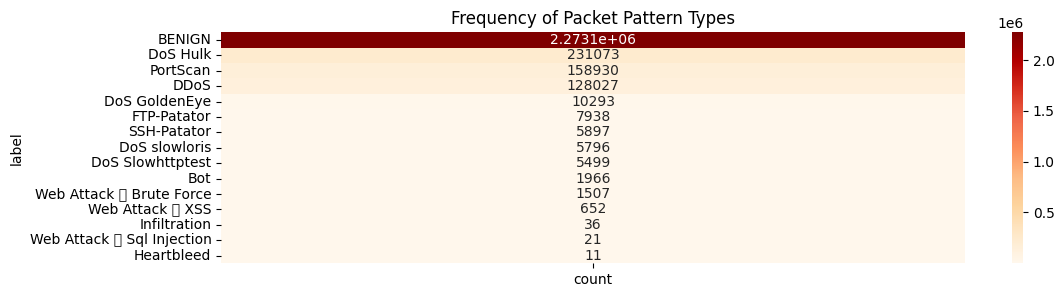

In [55]:
# static heatmap
heatmap_data = label_counts.set_index('label')  # label column to be on x-axis

plt.figure(figsize=(12, 3))
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='OrRd')
plt.title("Frequency of Packet Pattern Types")
plt.show()


# Since benign labeling takes up most of the count, let's get rid of it temporarely to focus on cyberattacks instead.

In [56]:
label_counts_clean = label_counts[label_counts['label'] != 'BENIGN']


In [57]:
# interactive heatmap

fig = px.imshow(
    [label_counts_clean['count']],  # put counts as a 2D array
    labels=dict(x="Attack Type", y="Frequency", color="Count"),
    x=label_counts_clean['label'],
    y=["Frequency"],  # single row
    color_continuous_scale='OrRd'
)

# RENDER ONCE MORE

fig.update_layout(title="Heatmap of Attack Types")
fig.show()


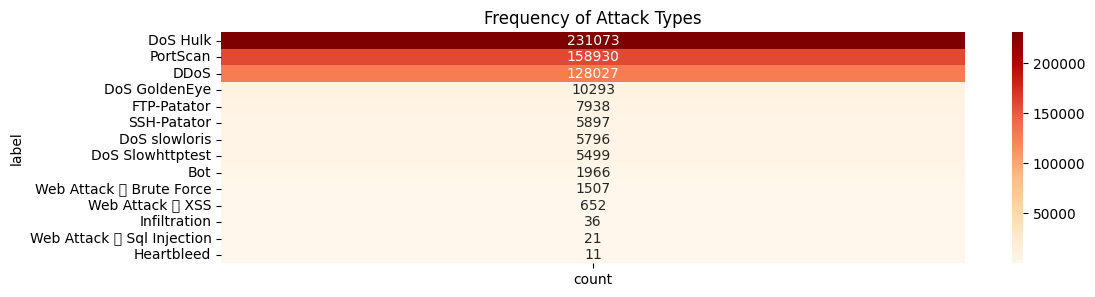

In [58]:
# static heatmap
heatmap_data = label_counts_clean.set_index('label')  # transposing to have labels on x-axis

plt.figure(figsize=(12, 3))
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='OrRd')
plt.title("Frequency of Attack Types")
plt.show()


In [59]:
# now that we both static and interactive heatmaps for all packet patterns and attack patterns.
# we can assign correct protocols to each packet based on destination port numbers. this is CRUCIAL for pattern recognition ML models.

ports = pd.read_csv(PORTS_PATH)
ports.head()

# that's right! that's the official IANA port number assignments list in CSV format :D


,Service Name,Port Number,Transport Protocol,Description,Assignee,Contact,Registration Date,Modification Date,Reference,Service Code,Unauthorized Use Reported,Assignment Notes
0,NaN,0,tcp,Reserved,NaN,NaN,NaN,2024-12-20,[RFC6335],NaN,NaN,NaN
1,NaN,0,udp,Reserved,NaN,NaN,NaN,2024-12-20,[RFC6335],NaN,NaN,NaN
2,tcpmux,1,tcp,TCP Port Service Multiplexer,[Mark_Lottor],[Mark_Lottor],NaN,NaN,NaN,NaN,NaN,NaN
3,tcpmux,1,udp,TCP Port Service Multiplexer,[Mark_Lottor],[Mark_Lottor],NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,2,tcp,Reserved,NaN,NaN,NaN,2025-02-13,NaN,NaN,NaN,"De-assigned on 2025-02-13, previously compress..."


In [60]:
# quick cleaning of the new ports df

ports.drop(['Description', 'Assignee', 'Contact', 'Registration Date', 'Modification Date', 'Reference', 'Service Code', 'Unauthorized Use Reported', 'Assignment Notes'], axis=1, inplace=True)
ports.columns = ports.columns.str.lower().str.replace(' ', '_')
ports.head(10)


,service_name,port_number,transport_protocol
0,NaN,0,tcp
1,NaN,0,udp
2,tcpmux,1,tcp
3,tcpmux,1,udp
4,NaN,2,tcp
5,NaN,2,udp
6,NaN,3,tcp
7,NaN,3,udp
8,NaN,4,tcp
9,NaN,4,udp


In [61]:
# making sure port numbers are numeric

ports['port_number'] = pd.to_numeric(ports['port_number'], errors='coerce')

# dropping rows where port_number is unknown, just to be safe

ports = ports.dropna(subset=['port_number'])


In [62]:
# here converting to int

ports['port_number'] = ports['port_number'].astype(int)
df['destination_port'] = df['destination_port'].astype(int)


In [63]:
# mapping numeric protocol to text: 6 is tcp, 17 is udp, 0 is HOPOPT (IPV6 extension header, rarely used but still valid)

proto_map = {6: 'tcp', 17: 'udp', 0: 'HOPOPT'}
df['protocol_text'] = df['protocol'].map(proto_map)


In [64]:
ports['transport_protocol'] = ports['transport_protocol'].str.lower()


In [65]:
# merging df with ports to get the service_name, instead of concat, to do a right join and keep all ports even if not in df

# collapse the ports lookup to a single row per port/protocol
ports_dedup = (
    ports.sort_values(['port_number', 'transport_protocol'])  # or any rule you like
         .drop_duplicates(subset=['port_number', 'transport_protocol'], keep='first')
)

df = df.merge(
    ports_dedup,
    left_on=['destination_port', 'protocol_text'],
    right_on=['port_number', 'transport_protocol'],
    how='left',
    validate='many_to_one'  # will raise if ports_dedup still has duplicates
)

In [66]:
# replacing protocol numbers with text (TCP/UDP/HOPOPT)

df['protocol'] = df['protocol_text'].str.upper()

# drop helper columns, no need for them

df.drop(['protocol_text', 'port_number', 'transport_protocol'], axis=1, inplace=True)

df['service_name'] = df['service_name'].fillna('unknown')


In [67]:
# finishing touches

df.dropna(subset=['label'], inplace=True)


In [68]:
# AND scramble because they're in order after merging by protocol.

df = df.sample(frac=1, random_state=42).reset_index(drop=True)


In [69]:
df.head()


,source_ip_address,source_port,destination_ip_address,destination_port,protocol,timestamp,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes_per_s,flow_packets_per_s,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fwd_header_length,bwd_header_length,fwd_packets_per_s,bwd_packets_per_s,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,cwe_flag_count,ece_flag_count,avg_fwd_segment_size,avg_bwd_segment_size,act_data_pkt_fwd,min_seg_size_forward,label,source_geo_location,destination_geo_location,service_name
0,192.168.10.16,41748,69.172.216.111,443,TCP,6/7/2017 4:49,870872,8,7,1623.0,3363.0,980.0,0.0,202.875000,361.405762,1448.0,0.0,480.428571,621.008550,5725.296025,17.224116,6.220514e+04,1.725598e+05,658089.0,4.0,828810.0,1.184014e+05,2.397097e+05,658089.0,210.0,831824.0,138637.3333,296075.807500,741379.0,4.0,0,0,0,0,264,232,9.186195,8.037921,0.0,1448.0,311.6250,491.215754,2.412929e+05,0,0,0,1,0,0,0,0,202.875000,480.428571,3,32,BENIGN,Unknown: Private IP,Canada,https
1,172.16.0.1,54756,192.168.10.50,80,TCP,5/7/2017 10:45,4,2,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,500000.000000,4.000000e+00,0.000000e+00,4.0,4.0,4.0,4.000000e+00,0.000000e+00,4.0,4.0,0.0,0.0000,0.000000,0.0,0.0,0,0,0,0,64,0,500000.000000,0.000000,0.0,0.0,0.0000,0.000000,0.000000e+00,0,0,0,0,1,0,0,0,0.000000,0.000000,0,32,DoS Hulk,Unknown: Private IP,Unknown: Private IP,http
2,52.84.145.207,443,192.168.10.25,60390,TCP,4/7/2017 2:42,70,1,1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,28571.428570,7.000000e+01,0.000000e+00,70.0,70.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0,0,0,0,32,32,14285.714290,14285.714290,0.0,0.0,0.0000,0.000000,0.000000e+00,0,0,0,0,1,1,0,0,0.000000,0.000000,0,32,BENIGN,United States,Unknown: Private IP,unknown
3,172.16.0.1,37624,192.168.10.50,80,TCP,5/7/2017 10:53,98543688,9,6,370.0,11595.0,364.0,0.0,41.111111,121.099592,4344.0,0.0,1932.500000,1754.831473,121.418228,0.152217,7.038835e+06,2.630000e+07,98500000.0,4.0,98500000.0,1.230000e+07,3.480000e+07,98500000.0,4.0,32436.0,6487.2000,9427.716675,21016.0,34.0,0,0,0,0,284,200,0.091330,0.060887,0.0,4344.0,747.8125,1390.190885,1.932631e+06,0,0,0,0,1,0,0,0,41.111111,1932.500000,2,20,DoS Hulk,Unknown: Private IP,Unknown: Private IP,http
4,192.168.10.19,2729,192.168.10.3,53,UDP,03/07/2017 01:48:31,61872,2,2,60.0,344.0,30.0,30.0,30.000000,0.000000,172.0,172.0,172.000000,0.000000,6529.609516,64.649599,2.062400e+04,3.571749e+04,61867.0,1.0,1.0,1.000000e+00,0.000000e+00,1.0,1.0,4.0,4.0000,0.000000,4.0,4.0,0,0,0,0,64,64,32.324800,32.324800,30.0,172.0,86.8000,77.776603,6.049200e+03,0,0,0,0,0,0,0,0,30.000000,172.000000,1,32,BENIGN,Unknown: Private IP,Unknown: Private IP,DNS


In [70]:
df['protocol'].value_counts()


protocol
TCP       1829554
UDP        999493
HOPOPT       1696
Name: count, dtype: int64

In [71]:
# previous operations resulted in turning all numeric columns into floats, so whole numbers get converted back to int

for col in df.select_dtypes(include='number').columns:

    # no fractions or decimals
    if (df[col] % 1 == 0).all():
        df[col] = df[col].astype(int)
        

In [72]:
df[['destination_port', 'protocol', 'service_name']].head(20)

# Making sure it works


,destination_port,protocol,service_name
0,443,TCP,https
1,80,TCP,http
2,60390,TCP,unknown
3,80,TCP,http
4,53,UDP,DNS
5,45755,TCP,unknown
6,80,TCP,http
7,80,TCP,http
8,53,UDP,DNS
9,443,TCP,https


In [73]:
df.dropna(inplace=True) 
df.shape


(2802684, 64)

# Machine Learning!

// up next, machine learning initiation, pattern detection models, and attempting to figure out WHY a certain set of packets are determined to be an attack.

// the type of model most appropriate for what project E aims for is a Train-Test Split model, since we are trying to identify a target, the target being 'label' in our new and improved dataset

First, multiclassification Train=Test Splitting

In [74]:
df.head()


,source_ip_address,source_port,destination_ip_address,destination_port,protocol,timestamp,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes_per_s,flow_packets_per_s,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fwd_header_length,bwd_header_length,fwd_packets_per_s,bwd_packets_per_s,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,cwe_flag_count,ece_flag_count,avg_fwd_segment_size,avg_bwd_segment_size,act_data_pkt_fwd,min_seg_size_forward,label,source_geo_location,destination_geo_location,service_name
0,192.168.10.16,41748,69.172.216.111,443,TCP,6/7/2017 4:49,870872,8,7,1623,3363,980,0,202.875000,361.405762,1448,0,480.428571,621.008550,5725.296025,17.224116,6.220514e+04,1.725598e+05,658089,4,828810,1.184014e+05,2.397097e+05,658089,210,831824,138637.3333,296075.807500,741379,4,0,0,0,0,264,232,9.186195,8.037921,0,1448,311.6250,491.215754,2.412929e+05,0,0,0,1,0,0,0,0,202.875000,480.428571,3,32,BENIGN,Unknown: Private IP,Canada,https
1,172.16.0.1,54756,192.168.10.50,80,TCP,5/7/2017 10:45,4,2,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,500000.000000,4.000000e+00,0.000000e+00,4,4,4,4.000000e+00,0.000000e+00,4,4,0,0.0000,0.000000,0,0,0,0,0,0,64,0,500000.000000,0.000000,0,0,0.0000,0.000000,0.000000e+00,0,0,0,0,1,0,0,0,0.000000,0.000000,0,32,DoS Hulk,Unknown: Private IP,Unknown: Private IP,http
2,52.84.145.207,443,192.168.10.25,60390,TCP,4/7/2017 2:42,70,1,1,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,28571.428570,7.000000e+01,0.000000e+00,70,70,0,0.000000e+00,0.000000e+00,0,0,0,0.0000,0.000000,0,0,0,0,0,0,32,32,14285.714290,14285.714290,0,0,0.0000,0.000000,0.000000e+00,0,0,0,0,1,1,0,0,0.000000,0.000000,0,32,BENIGN,United States,Unknown: Private IP,unknown
3,172.16.0.1,37624,192.168.10.50,80,TCP,5/7/2017 10:53,98543688,9,6,370,11595,364,0,41.111111,121.099592,4344,0,1932.500000,1754.831473,121.418228,0.152217,7.038835e+06,2.630000e+07,98500000,4,98500000,1.230000e+07,3.480000e+07,98500000,4,32436,6487.2000,9427.716675,21016,34,0,0,0,0,284,200,0.091330,0.060887,0,4344,747.8125,1390.190885,1.932631e+06,0,0,0,0,1,0,0,0,41.111111,1932.500000,2,20,DoS Hulk,Unknown: Private IP,Unknown: Private IP,http
4,192.168.10.19,2729,192.168.10.3,53,UDP,03/07/2017 01:48:31,61872,2,2,60,344,30,30,30.000000,0.000000,172,172,172.000000,0.000000,6529.609516,64.649599,2.062400e+04,3.571749e+04,61867,1,1,1.000000e+00,0.000000e+00,1,1,4,4.0000,0.000000,4,4,0,0,0,0,64,64,32.324800,32.324800,30,172,86.8000,77.776603,6.049200e+03,0,0,0,0,0,0,0,0,30.000000,172.000000,1,32,BENIGN,Unknown: Private IP,Unknown: Private IP,DNS


In [75]:
# columns to drop further for analysis and ML modeling

drop_cols = [
    'source_ip_address', 
    'source_port', 
    'destination_ip_address', 
    'timestamp',            # to fight memory bias
    'source_geo_location',
    'destination_geo_location',
    'min_packet_length',   # redundant with mean/std/max
    'packet_length_variance',  # redundant with std
    'avg_fwd_segment_size',  # redundant with fwd_packet_length_mean
    'avg_bwd_segment_size',
    'flow_bytes_per_s',
    'flow_packets_per_s',
    'fwd_iat_total',
    'fwd_iat_max',
    'bwd_iat_total',
    'bwd_iat_max',
    'fwd_packet_length_std',
    'bwd_packet_length_std',
    'urg_flag_count',
    'ece_flag_count',
    'cwe_flag_count',
    'bwd_psh_flags',
    'bwd_urg_flags',
    'act_data_pkt_fwd',
    'min_seg_size_forward'   # redundant with bwd_packet_length_mean
]

df = df.drop(columns=drop_cols)

# seeing what we have

print("Remaining columns:", df.columns.tolist())


Remaining columns: ['destination_port', 'protocol', 'flow_duration', 'total_fwd_packets', 'total_backward_packets', 'total_length_of_fwd_packets', 'total_length_of_bwd_packets', 'fwd_packet_length_max', 'fwd_packet_length_min', 'fwd_packet_length_mean', 'bwd_packet_length_max', 'bwd_packet_length_min', 'bwd_packet_length_mean', 'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_min', 'bwd_iat_mean', 'bwd_iat_std', 'bwd_iat_min', 'fwd_psh_flags', 'fwd_urg_flags', 'fwd_header_length', 'bwd_header_length', 'fwd_packets_per_s', 'bwd_packets_per_s', 'max_packet_length', 'packet_length_mean', 'packet_length_std', 'fin_flag_count', 'syn_flag_count', 'rst_flag_count', 'psh_flag_count', 'ack_flag_count', 'label', 'service_name']


In [76]:
df.shape



(2802684, 39)

In [77]:
# first setting target and features.

y = df['label'] # label as target
X = df.drop(columns=['label']) # everything else as features, very easily customizable later on should we drop or add columns


In [78]:
# encoding categorical features (important for ML models)

X_encoded, le_dict = encode_features(X)


In [79]:
# Train-test split (stratify to keep class proportions)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.10, random_state=32, stratify=y
)


In [80]:
# max value is set to one billion to manage extreme outliers
# models also won't run without it, consumer hardware limitations

max_val = 1e9
X_train = X_train.clip(-max_val, max_val)
X_test = X_test.clip(-max_val, max_val)


In [81]:
# balancing time

X_train_bal, y_train_bal = X_train, y_train


In [82]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=7, # I optimized these hyperparameters through experimentation, a lot of experimentation, and anything above a 7 max depth resulted in overfitting, as far as multiclassification goes.
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',  # handles imbalance
    n_jobs=-1,                 # use all available cores (AMD RYZEN 9 9950X)
    random_state=32
)

# training
rf.fit(X_train_bal, y_train_bal)

# note to self: don't forget to expand parameters tab.

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",7
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",20
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",10
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(

In [83]:
# actual predictions

y_pred = rf.predict(X_test)

print("> Multi-Classification Report <")
print(classification_report(y_test, y_pred, zero_division=0))


> Multi-Classification Report <
                            precision    recall  f1-score   support

                    BENIGN       1.00      0.89      0.94    224599
                       Bot       0.02      1.00      0.05       197
                      DDoS       0.98      1.00      0.99     12803
             DoS GoldenEye       0.69      0.99      0.81      1029
                  DoS Hulk       0.83      0.96      0.89     23012
          DoS Slowhttptest       0.59      0.90      0.72       550
             DoS slowloris       0.54      0.85      0.66       580
               FTP-Patator       0.95      1.00      0.97       794
                Heartbleed       0.50      1.00      0.67         1
              Infiltration       1.00      0.67      0.80         3
                  PortScan       0.98      1.00      0.99     15893
               SSH-Patator       0.58      1.00      0.74       590
  Web Attack  Brute Force       0.03      0.38      0.06       151
Web Attack  Sq

// Notes:

This the multi-classification process above took around 4 hours of total training until I finally parametered a model that didn't overfit.

Things I've attempted:
- Used Smote in order to compensate for the skewed dataset when it comes to balance, (took too long and crashed my computer a couple of times. Even when it didn't crash, and limited the CPU cores allowed by half, it still takes way too long.)
- Drop what I suspected were data noise, resulting in less columns (down to 39)
- Reduced the percentage of the test size down to 5%, from the standard 30%. 10% seems to be optimal though. 
- Tried multiple random states (very low impact)


Addtional notes: 

I wanted to classify the very small samples in the data set, like SQL injections, Heartbleed, SSH patator and such as (Other Attacks). However, with more, this model can excel with additional data! Besides, the traffic percentages is realistic to what's seen in the real world world. Most traffic indeed is benign, a small percentage of global traffic are associated with attacks. So these are realistic conditions and that's what IDS systems have to work with. 

# Additional Multi-classification experimentation:

In [84]:
attack_counts = df['label'].value_counts()

# setting attack counts for the lambda function below

In [85]:
threshold = 5000  # we set minimum support to be kept as individual class for the reduces multiclassification
df['label_multiclass_adj'] = df['label'].apply(
    lambda x: x if attack_counts[x] >= threshold else 'OTHER'
)


In [86]:
# setting targets once more

y = df['label_multiclass_adj']
X = df.drop(columns=['label', 'label_multiclass_adj'])

# encoding

X_encoded, le_dict = encode_features(X)


In [87]:
# train/test split parameters

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.10, random_state=32, stratify=y
)


In [88]:
max_val = 1e9 # a billion again for outliers
X_train = X_train.clip(-max_val, max_val)
X_test = X_test.clip(-max_val, max_val)


In [89]:
X_train_bal, y_train_bal = X_train, y_train

# making sure the balanced sets are used


In [90]:
# rf for randomforest

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=7,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',
    n_jobs=-1,
    random_state=32
)

rf.fit(X_train_bal, y_train_bal)

# note to self: don't forget to expand parameters tab.

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",7
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",20
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",10
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(

In [91]:
y_pred = rf.predict(X_test)

print("> Reduced Multi-Classification Report <")
print(classification_report(y_test, y_pred, zero_division=0))

# prediciting and report printing

> Reduced Multi-Classification Report <
                  precision    recall  f1-score   support

          BENIGN       1.00      0.93      0.96    224599
            DDoS       0.96      1.00      0.98     12803
   DoS GoldenEye       0.74      0.99      0.84      1029
        DoS Hulk       0.87      0.99      0.93     23012
DoS Slowhttptest       0.70      0.96      0.81       550
   DoS slowloris       0.65      0.97      0.78       580
     FTP-Patator       1.00      1.00      1.00       794
           OTHER       0.03      0.99      0.07       419
        PortScan       0.99      1.00      0.99     15893
     SSH-Patator       0.64      1.00      0.78       590

        accuracy                           0.94    280269
       macro avg       0.76      0.98      0.81    280269
    weighted avg       0.98      0.94      0.96    280269



# Up next, the binary classification model.

In [92]:
# here we create binary label

df_binary = df.copy()
df_binary['label_binary'] = df_binary['label'].apply(lambda x: 'BENIGN' if x == 'BENIGN' else 'SUSPICIOUS')

# dropping the previous "label" column (took way too long to spot this small detail)
df_binary = df_binary.drop(columns=['label'])


In [93]:
y = df_binary['label_binary']
X = df_binary.drop(columns=['label_binary'])



In [94]:
# eccoding categorical features
X_encoded, le_dict = encode_features(X)

    

In [95]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=32, stratify=y
)


In [96]:
rf_binary = RandomForestClassifier(
    n_estimators=100,
    max_depth=4,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced', 
    n_jobs=-1, # enabling all cores, fine if it's just binary. 
    random_state=42
)


In [97]:
print(pd.Series(y_train).value_counts())
print(pd.Series(y_test).value_counts())


label_binary
BENIGN        1796789
SUSPICIOUS     445358
Name: count, dtype: int64
label_binary
BENIGN        449198
SUSPICIOUS    111339
Name: count, dtype: int64


In [98]:
# acively training

rf_binary.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",4
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",10
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [99]:
# predicting

y_pred = rf_binary.predict(X_test)


In [100]:
# eval

print("> Binary Classification Report <")
print(classification_report(y_test, y_pred, zero_division=0))


> Binary Classification Report <
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00    449198
  SUSPICIOUS       1.00      1.00      1.00    111339

    accuracy                           1.00    560537
   macro avg       1.00      1.00      1.00    560537
weighted avg       1.00      1.00      1.00    560537



In [101]:
print("> Confusion Matrix <")
cm = confusion_matrix(y_test, y_pred, labels=['BENIGN', 'ATTACK'])
print(cm)


> Confusion Matrix <
[[449198      0]
 [     0      0]]


At first glance, this may seem like overfitting, but it isn't. 

Looking back at the multi-classification it performed surprisingly well, 0.88 accuracy with skewed data indicated not only good parameters, but a very high quality data set, alongside it's enrichment.

This is even more impressive considering we are treating each packet as an individual observation, rather than a timestamped log, which is what you see in live IDS systems. 

# Finally, cross validation accross multiple models

In [102]:
# --- k-fold and scorer ---

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=32)
f1_macro_scorer = make_scorer(f1_score, average='macro')


In [103]:
# encode labels for multi-class/macro F1

le = LabelEncoder()
y_encoded = le.fit_transform(y)  # BENIGN > 0, ATTACK > 1


In [104]:
# Prep data use OG multi-class labels
y_multi = df['label']
X_multi = df.drop(columns=['label', 'label_multiclass_adj'])  # drop both label columns if there

# encode categorical features, standard procedure
cat_cols = X_multi.select_dtypes(include='object').columns
X_multi_encoded = X_multi.copy()

for col in cat_cols:
    le = LabelEncoder()
    X_multi_encoded[col] = le.fit_transform(X_multi_encoded[col].astype(str))

# encoding target labels
le_target = LabelEncoder()
y_multi_encoded = le_target.fit_transform(y_multi)

# k-fold setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=32)

# all 4 models
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=200,
        max_depth=7,
        min_samples_split=20,
        min_samples_leaf=10,
        class_weight='balanced',
        n_jobs=-1,
        random_state=32
    ),
    "XGBoost": xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric='mlogloss',
        n_jobs=-1,
        random_state=32
    ),
    "CatBoost": CatBoostClassifier(
        iterations=100,
        depth=6,
        learning_rate=0.1,
        silent=True,
        random_seed=32
    ),
    "LightGBM": lgb.LGBMClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        class_weight='balanced',
        n_jobs=-1,
        random_state=32
    )
}


In [ ]:
# this is an iteration through each model in the dictionary for k-fold cross-validation
for name, model in models.items():
    print(f"> {name} (Multi-Class) <")
    
    f1_scores_list = []
    accuracy_scores_list = []

    # here we split the data into 5 folds and iterate through each fold
    for train_idx, test_idx in kf.split(X_multi_encoded, y_multi_encoded):
        # for the CURRENT fold, get train and test data. not all of them.
        X_train, X_test = X_multi_encoded.iloc[train_idx], X_multi_encoded.iloc[test_idx]
        y_train, y_test = y_multi_encoded[train_idx], y_multi_encoded[test_idx]

        model_fold = copy.deepcopy(model)
        
        model_fold.fit(X_train, y_train)
        
        y_pred = model_fold.predict(X_test)

        # calculate macro F1 scores and accuracy scores and store them
        f1_scores_list.append(f1_score(y_test, y_pred, average='macro'))
        accuracy_scores_list.append(accuracy_score(y_test, y_pred))

    # cross-validation results with mean and standard deviation
    # note to self: discuss this.
    print("> Multi-Class K-Fold Cross-Validation <\n")
    print(f"Mean Macro F1: {np.mean(f1_scores_list):.4f} ± {np.std(f1_scores_list):.4f}")
    print(f"Mean Accuracy: {np.mean(accuracy_scores_list):.4f} ± {np.std(accuracy_scores_list):.4f}\n")

    # the number of iterations scales with the number of models and model paramateres we place in the 'models' dictionary in the cell above

GitHub Display Only

---------------------------------------------

 RandomForest (Multi-Class) 
 Multi-Class K-Fold Cross-Validation 

Mean Macro F1: 0.6320 ± 0.0102
Mean Accuracy: 0.9144 ± 0.0019

 XGBoost (Multi-Class) 
 Multi-Class K-Fold Cross-Validation 

Mean Macro F1: 0.8083 ± 0.0312
Mean Accuracy: 0.9977 ± 0.0000

 CatBoost (Multi-Class) 
 Multi-Class K-Fold Cross-Validation 

Mean Macro F1: 0.6707 ± 0.0024
Mean Accuracy: 0.9961 ± 0.0002

 LightGBM (Multi-Class) 

Mean Macro F1: 0.4459 ± 0.3085
Mean Accuracy: 0.6586 ± 0.2976